In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default() 
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package libfuse2:amd64.
(Reading database ... 26397 files and directories currently installed.)
Preparing to unpack .../libfuse2_2.9.7-1ubuntu1_amd64.deb ...
Unpacking libfuse2:amd64 (2.9.7-1ubuntu1) ...
Selecting previously unselected package fuse.
Preparing to unpack .../fuse_2.9.7-1ubuntu1_amd64.deb ...
Unpacking fuse (2.9.7-1ubuntu1) ...
Selecting previously unselected package google-drive-ocamlfuse.
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Setting up libfuse2:amd64 (2.9.7-1ubuntu1) ...
Processing triggers for libc-bin (2.27-3ubuntu1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Setting up fuse (2.9.7-1ubuntu1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu2~ubuntu18.04.1) ...
Please, open the following URL in a web browser: https://accounts.google

In [2]:
!pip3 install SimpleITK

    100% |████████████████████████████████| 41.0MB 1.2MB/s 


In [3]:

import os
os.chdir('drive/paperImp2016')
!ls
import os
import SimpleITK as sitk
import numpy as np

2016				  Old_input_cascasde_acc.h5  slice_126_4
Backup_Old_input_cascasde_acc.h5  SaveTwoPathModelBackup.h5  slice_255_4
HG				  slice_110_4		     twoPathModel.h5


In [4]:
import os
path = 'HG/0001/'
p = os.listdir(path)
p.sort(key=str.lower)
arr = []
for i in range(len(p)):
  if(i != 4):
    p1 = os.listdir(path+'/'+p[i])
    p1.sort()
    img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
    arr.append(sitk.GetArrayFromImage(img))
  else:
    p1 = os.listdir(path+'/'+p[i])
    img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
    Y_labels = sitk.GetArrayFromImage(img) 
    print(Y_labels.shape)
data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
for i in range(Y_labels.shape[1]):
  data[i,:,:,0] = arr[0][:,i,:]
  data[i,:,:,1] = arr[1][:,i,:]
  data[i,:,:,2] = arr[2][:,i,:]
  data[i,:,:,3] = arr[3][:,i,:]

(176, 216, 160)


Populating the interactive namespace from numpy and matplotlib


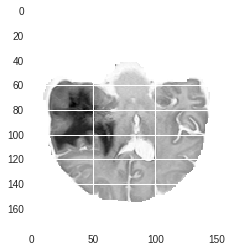

In [5]:
%pylab inline
import matplotlib.pyplot as plt
img = data[110,:,:,0]
imgplot = plt.imshow(img)
plt.show()
plt.imsave('slice_110_4',img,cmap='gray')

Populating the interactive namespace from numpy and matplotlib


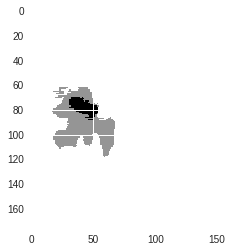

In [6]:
%pylab inline
import matplotlib.pyplot as plt
img = Y_labels[:,110,:]
imgplot = plt.imshow(img)
plt.show()

In [0]:
def model_gen(input_dim,x,y,slice_no):
  X1 = []
  X2 = []
  Y = []
  
  for i in range(int((input_dim)/2),y.shape[0]-int((input_dim)/2)):
    for j in range(int((input_dim)/2),y.shape[2]-int((input_dim)/2)):
      #Filtering all 0 patches
      if(x[i-16:i+17,j-16:j+17,:].any != 0):
        X2.append(x[i-16:i+17,j-16:j+17,:])
        X1.append(x[i-int((input_dim)/2):i+int((input_dim)/2)+1,j-int((input_dim)/2):j+int((input_dim)/2)+1,:])
        Y.append(y[i,slice_no,j])
      
      
  X1 = np.asarray(X1)
  X2 = np.asarray(X2)
  Y = np.asarray(Y)
  d = [X1,X2,Y]
  return d

In [0]:
def data_gen(data,y,slice_no,model_no):
  d = []
  x = data[slice_no]
  #filtering all 0 slices and non-tumor slices
  if(x.any() != 0 and y.any() != 0):
    if(model_no == 0):
      X1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            X1.append(x[i-16:i+17,j-16:j+17,:])
      Y1 = []
      for i in range(16,159):
        for j in range(16,199):
          if(x[i-16:i+17,j-16:j+17,:].all != 0):
            Y1.append(y[i,slice_no,j]) 
      X1 = np.asarray(X1)
      Y1 = np.asarray(Y1)
      d = [X1,Y1]
    elif(model_no == 1):
      d = model_gen(65,x,y,slice_no)
    elif(model_no == 2):
      d = model_gen(56,x,y,slice_no)
    elif(model_no == 3):
      d = model_gen(53,x,y,slice_no)  
    
  return d

In [9]:
import keras
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add
from keras.models import Model
from keras import regularizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from keras.initializers import glorot_normal
#import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

Using TensorFlow backend.


In [0]:

def two_path(X_input):
  
  #Local Path 1
  X = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X = BatchNormalization()(X)
  X1 = Conv2D(64,(7,7),strides=(1,1),padding='valid')(X_input)
  X1 = BatchNormalization()(X1)
  X = layers.Maximum()([X,X1])
  X = Conv2D(64,(4,4),strides=(1,1),padding='valid',activation='relu')(X)
  #Global Path 1
  X2 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X2 = BatchNormalization()(X2)
  X21 = Conv2D(160,(13,13),strides=(1,1),padding='valid')(X_input)
  X21 = BatchNormalization()(X21)
  X2 = layers.Maximum()([X2,X21])
  #Local Path 2
  X3 = Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X3 = BatchNormalization()(X3)
  X31 =  Conv2D(64,(3,3),strides=(1,1),padding='valid')(X)
  X31 = BatchNormalization()(X31)
  X = layers.Maximum()([X3,X31])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(X)
  #Global Path 2
  X4 = Conv2D(160,(6,6),strides=(1,1),padding='valid')(X2)
  X4 = BatchNormalization()(X4)
  X41 = Conv2D(160,(6,6),strides=(1,1),padding='valid')(X2)
  X41 = BatchNormalization()(X41)
  X4 = layers.Maximum()([X4,X41])
  #Local Path 3
  X5 = Conv2D(64,(5,5),strides=(1,1),padding='valid')(X)
  X5 = BatchNormalization()(X5)
  X51 =  Conv2D(64,(5,5),strides=(1,1),padding='valid')(X)
  X51 = BatchNormalization()(X51)
  X = layers.Maximum()([X5,X51])
  X = Conv2D(64,(2,2),strides=(1,1),padding='valid',activation='relu')(X)
  
  X = Concatenate()([X4,X])
  #X = Conv2D(5,(21,21),strides=(1,1))(X)
  #X = Activation('softmax')(X)
  
  #model = Model(inputs = X_input, outputs = X)
  return X

In [0]:
def input_cascade(input_shape1,input_shape2):
  
  X1_input = Input(input_shape1)
  X1 = two_path(X1_input)
  X1 = Conv2D(5,(16,16),strides=(1,1),padding='valid',activation='relu')(X1)
  X1 = BatchNormalization()(X1)
  
  X2_input = Input(input_shape2)
  X2_input1 = Concatenate()([X1,X2_input])
  #X2_input1 = Input(tensor = X2_input1)
  X2 = two_path(X2_input1)
  X2 = Conv2D(5,(16,16),strides=(1,1),padding='valid')(X2)
  X2 = BatchNormalization()(X2)
  X2 = Activation('softmax')(X2)
  
  model = Model(inputs=[X1_input,X2_input],outputs=X2)
  return model

In [12]:
m1 = input_cascade((65,65,4),(33,33,4))
m1.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
#m1 = keras.models.load_model()
m1.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 65, 65, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 59, 59, 64)   12608       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 59, 59, 64)   256         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_norm

In [0]:
from sklearn.utils import class_weight
import os

In [14]:
fold = os.listdir('HG/')
fold.sort(key=str.lower) 

for path in fold:
    print(path)
    path = 'HG/' +path
    p = os.listdir(path)
    p.sort(key=str.lower)
    arr = []
    
    # Reading from 4 images and creating 4 channel slice-wise 
    for i in range(len(p)):
      if(i != 4):
        p1 = os.listdir(path+'/'+p[i])
        p1.sort()
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[-1])
        arr.append(sitk.GetArrayFromImage(img))
      else:
        p1 = os.listdir(path+'/'+p[i])
        img = sitk.ReadImage(path+'/'+p[i]+'/'+p1[0])
        Y_labels = sitk.GetArrayFromImage(img)
    data = np.zeros((Y_labels.shape[1],Y_labels.shape[0],Y_labels.shape[2],4))
    for i in range(Y_labels.shape[1]):
      data[i,:,:,0] = arr[0][:,i,:]
      data[i,:,:,1] = arr[1][:,i,:]
      data[i,:,:,2] = arr[2][:,i,:]
      data[i,:,:,3] = arr[3][:,i,:]
    print(data.shape)
    info = []
    
    # Creating patches for each slice and training(slice-wise)
    for i in range(data.shape[0]-66):
      d = data_gen(data,Y_labels,i,1)
      if(len(d) != 0):
        y = np.zeros((d[2].shape[0],1,1,5))
        for j in range(y.shape[0]):
          y[j,:,:,d[2][j]] = 1
        X1 = d[0]
        X2 = d[1]
        class_weights = class_weight.compute_class_weight('balanced',
                                                          np.unique(d[2]),
                                                          d[2])
        print('slice no:'+str(i))
        info.append(m1.fit([X1,X2],y,epochs=5,batch_size=128,class_weight= class_weights))
        m1.save('Defance2PathCnnModel.h5')
        m1.save('BackUpDefance2PathCnnModel.h5')


0001
(216, 176, 160, 4)
slice no:20
Epoch 1/5
 7168/10752 [===================>..........] - ETA: 50s - loss: 1.5800 - acc: 0.7946

KeyboardInterrupt: ignored